## Introduction and Data

In this report, I aim to model exam scores both pre-COVID (when in-person examinations took place) and post-COVID (when exams were online). I collected data from [Course Results obtained from the LSE website](https://info.lse.ac.uk/staff/divisions/academic-registrars-division/systems/what-we-do/internal/degree-and-course-results). This included scores from the last 5 years (2016/17-2020/21). Different courses use different examination methods and will experience different impacts from COVID, particularly in 2020 when LT exams were held in-person but ST exams were not. I therefore founded my model parameters based on a few first-year BSc Economics courses: MA100, EC100, EC102, and ST102. These courses are all largely examined in the ST, and they have a large body of students taking them. The methods I use should be more broadly applicable, and I urge for a more comprehensive analysis to be done with a larger dataset.

## Distributions

As my dataset did not contain the precise values of scores, I visually examined the score distribution density to identify a distribution type that would best suit the data. From my observation, the data is rather normally-distributed, but skewed slightly to the left. I've attached the distributions from these four courses below:
|||
|:--:|:--:|
|MA100|ST102|
|![MA100](images/MA100_graph.png)|![ST102](images/ST102_graph.png)|
|EC100|EC102|
|![EC100](images/EC100_graph.png)|![EC102](images/EC102_graph.png)|

I recorded the $\mu_x$, $median_x$, and $\sigma_x$ for each course [here](data/score_data.csv). I averaged each of these properties to obtain a final $\mu$, $median$, and $\sigma$. For this model, I set the total population of students $(n) = 1000$

As I did not have specific data regarding modes, I calculated the skewness factor using [Pearson's Median Skewness Coefficient](https://mathworld.wolfram.com/PearsonsSkewnessCoefficients.html), which considers mean, median, and standard deviation:

$$\frac{3(\mu-median)}{\sigma}$$

I defined a function, `pearson_skew`, which can generate this.

I used the `seaborn.stats.skewnorm.rvs` function to create distributions based on the $\mu, \sigma, \& \; n$ calculated. However, the arguments it takes (mean, standard deviation, and a skewness parameter) $\neq$ the overall mean, standard deviation, and skewness of the resulting distribution. This is because the function skews the original Gaussian distribution, distorting the properties of the distribution.

To resolve this, I defined a function which would check the output factors and modify the original argument parameters until it was correct within a number of decimal places defined as `acc`. As this is computationally cumbersome, I have set `acc` to 2. Any larger and it takes too long to process.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#accuracy level, margin of error in decimal places
acc = 1

In [3]:
def pearson_skew(mean, median, stdev):
    return round(3*(mean-median)/stdev, acc)

In [4]:
def skew_norm(n, mean, stdev, median):
    # create the skew coeff:
    skew_coeff = pearson_skew(mean, median, stdev)
    plot_mean = mean
    plot_stdev = stdev
    plot_skew = skew_coeff
    
    skew_dist = stats.skewnorm.rvs(a=plot_skew, size = n, loc = plot_mean, scale = plot_stdev)
    
    while(round(np.mean(skew_dist), acc) != mean or round(np.std(skew_dist), acc) != stdev or pearson_skew(np.mean(skew_dist), np.median(skew_dist), np.std(skew_dist))!= skew_coeff):
        if(round(np.mean(skew_dist), acc) < mean):
            plot_mean+=10**(-1*acc -1)
        elif(round(np.mean(skew_dist), acc) > mean):
            plot_mean-=10**(-1*acc -1)
        if(round(np.std(skew_dist), acc) < stdev):
            plot_stdev+=10**(-1*acc -1)
        elif(round(np.std(skew_dist), acc) > stdev):
            plot_stdev-=10**(-1*acc -1)
        if(round(stats.skew(skew_dist), acc) < skew_coeff):
            plot_skew+=10**(-1*acc -1)
        elif(round(stats.skew(skew_dist), acc) > skew_coeff):
            plot_skew-=10**(-1*acc -1)
        skew_dist = stats.skewnorm.rvs(a=plot_skew, size = n, loc = plot_mean, scale = plot_stdev)
    
    return skew_dist

In [83]:
data = pd.read_csv('data/score_data.csv')
pre_covid = np.where(data['year'] < 2020)
pc_data = data.loc[pre_covid]
pc_median = round(np.mean(pc_data['median']), acc)
pc_stdev = round(np.mean(pc_data['stdev']), acc)
pc_mean = round(np.mean(pc_data['mean']), acc)
n = 1000
first_mark = 70

## Pre-COVID 

To start with, I will generate a distribution of pre-COVID scores. Above, I have chosen statistical parameters that are from the pre-COVID era.

One can see that there are a few scores generated which are larger than 100. Though these are not values which would exist in these contexts, I have left them for statistical purity.

I have also labelled $x=70$, the mark at which students will start earning a first. 

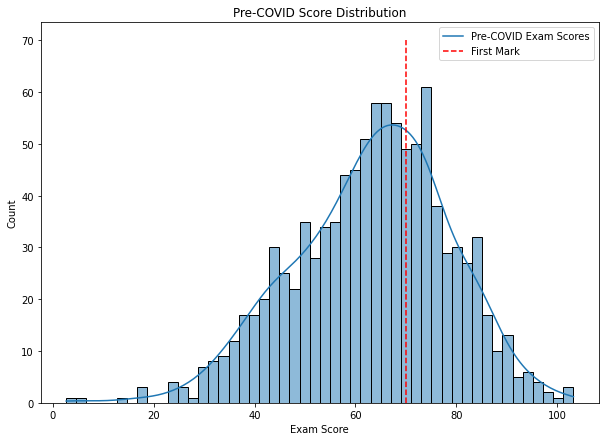

In [6]:
pc_dist = skew_norm(n=n, mean=pc_mean, stdev=pc_stdev, median=pc_median)
plt.figure(figsize=(10,7))
sns.histplot(x=pc_dist, kde = True, label = 'Exam Dist', stat='count', bins=50)
plt.vlines(first_mark, 0, 70, color='r', label='First', colors="r", linestyles='dashed')
plt.title('Pre-COVID Score Distribution')
plt.xlabel('Exam Score')
plt.legend(['Pre-COVID Exam Scores', 'First Mark'])
plt.show()

From this we can generate relevant values. `mark_prop` calculates a cumulative value for a given distribution and point.

`Seaborn` will also let us create an ecdf (empirical cumulative distribution function) based on our generated distribution.

In [82]:
def mark_cdf(mark, dist):
    sorted_dist = np.sort(dist)
    cdf_values = np.arange(n) / n
    cdf = np.interp(mark,sorted_dist, cdf_values)
    return(cdf)

In [8]:
first_prop = 1-mark_cdf(first_mark, pc_dist)
print('Approximately', str(round(100*first_prop, 2))+'% of students got a first before COVID-19 turned exams online.')

Approximately 35.31% of students got a first before COVID-19 turned exams online.


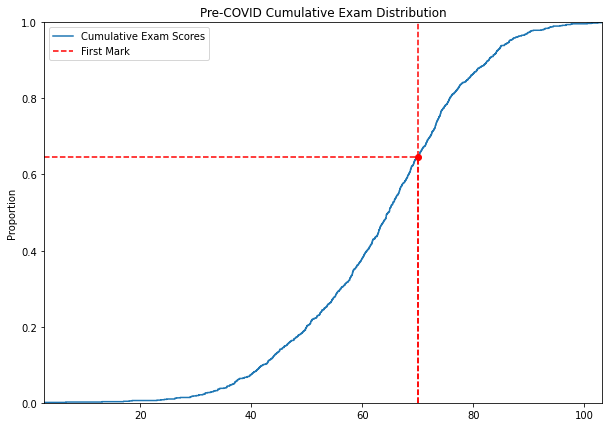

In [9]:
plt.figure(figsize=(10,7))
sns.ecdfplot(data=pc_dist)
plt.vlines(first_mark, 0, 1, color='r', label='First', colors="r", linestyles='dashed')
plt.plot([first_mark], [1-first_prop], marker = 'o', color = 'red')
plt.hlines(y=1-first_prop, xmin=np.interp(0, np.arange(n)/n, np.sort(pc_dist)), xmax=first_mark,colors='red',linestyles='dashed')
plt.vlines(x=first_mark, ymin=0, ymax = 1-first_prop, colors= 'red', linestyles='dashed')
plt.legend(['Cumulative Exam Scores', 'First Mark'])
plt.margins(0)
plt.title('Pre-COVID Cumulative Exam Distribution')
plt.show()

In [10]:
post_covid = np.where(data['year']>=2020)
post_c_data = data.loc[post_covid]
post_c_median = round(np.mean(post_c_data['median']), acc)
post_c_stdev = round(np.mean(post_c_data['stdev']), acc)
post_c_mean = round(np.mean(post_c_data['mean']), acc)
post_c_skew = pearson_skew(mean=post_c_mean, median=post_c_median, stdev = post_c_stdev)

In [11]:
print('Pre-COVID vs Post-COVID Overview \n')
print('Pre-COVID Mean: ', pc_mean)
print('Post-COVID Mean: ', post_c_mean)
print('Pre-COVID Median: ', pc_median)
print('Post-COVID Median: ', post_c_median)
print('Pre-COVID SD: ', pc_stdev)
print('Post-COVID SD: ', post_c_stdev)
print('Pre-COVID Skew: ', pearson_skew(mean=pc_mean, median=pc_median, stdev=pc_stdev))
print('Post-COVID Skew: ', round(post_c_skew, acc))

Pre-COVID vs Post-COVID Overview 

Pre-COVID Mean:  63.3
Post-COVID Mean:  69.4
Pre-COVID Median:  64.6
Post-COVID Median:  70.5
Pre-COVID SD:  15.4
Post-COVID SD:  12.1
Pre-COVID Skew:  -0.3
Post-COVID Skew:  -0.3


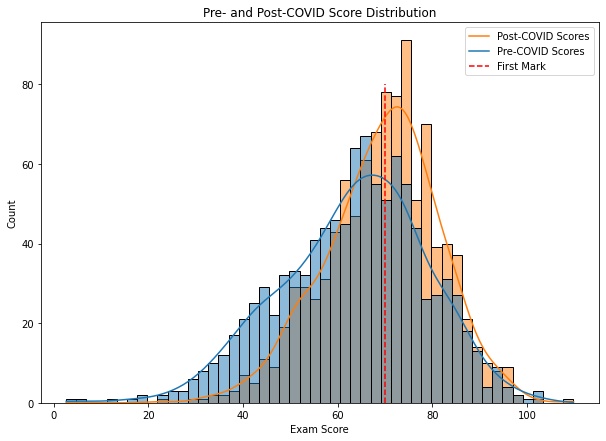

In [12]:
online_dist = skew_norm(n=n, mean=post_c_mean, stdev=post_c_stdev, median=post_c_median)
plt.figure(figsize=(10,7))
sns.histplot(data=[pc_dist, online_dist], kde = True, label = 'Exam Dist', stat='count', bins=50, multiple='layer')
plt.vlines(first_mark, 0, 80, color='r', label='First', colors="r", linestyles='dashed')
plt.title('Pre- and Post-COVID Score Distribution')
plt.xlabel('Exam Score')
plt.legend(['Post-COVID Scores', 'Pre-COVID Scores', 'First Mark'])
plt.show()

In [13]:
online_first_prop = 1-mark_cdf(first_mark, online_dist)
print(str(round(100*online_first_prop, 2))+'% of students got a first after COVID-19 turned exams online., compared to', str(round(100*first_prop, 2))+'% before COVID.')

51.28% of students got a first after COVID-19 turned exams online., compared to 35.31% before COVID.


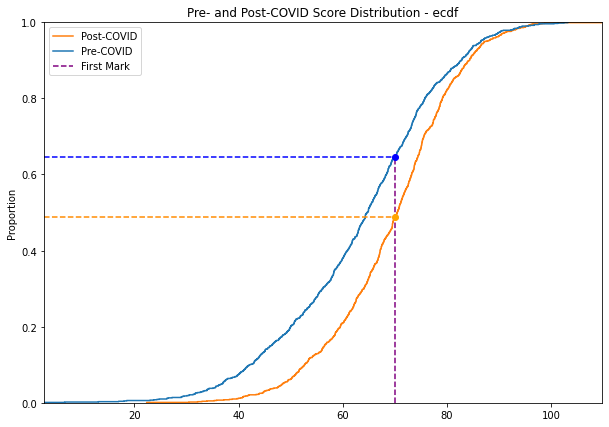

In [14]:
plt.figure(figsize=(10,7))
sns.ecdfplot([pc_dist,online_dist])
plt.vlines(x=first_mark, ymin=0, ymax = 1-first_prop, colors= 'purple', linestyles='dashed')
plt.hlines(y=1-first_prop, xmin=np.interp(0, np.arange(n)/n, np.sort(pc_dist)), xmax=first_mark,colors='blue',linestyles='dashed')
plt.hlines(y=1-online_first_prop, xmin=np.interp(0, np.arange(n)/n, np.sort(pc_dist)), xmax=first_mark,colors='darkorange',linestyles='dashed')
plt.plot([first_mark], [1-first_prop], marker = 'o', color = 'blue', linestyle = 'dashed')
plt.plot([first_mark], [1-online_first_prop], marker = 'o', color = 'orange', linestyle = 'dashed')
plt.margins(0)
plt.legend(['Post-COVID', 'Pre-COVID', 'First Mark'])
plt.title('Pre- and Post-COVID Score Distribution - ecdf')
plt.show()

## Post-COVID

What happened as examinations were held online? Primarily, we see an increase in $\mu$ and a decrease in $\sigma$. I posit that this is because of two reasons:

- Firstly, all students are able to access course materials while taking the exam. As students don't need to memorise course content, they may be able to perform better on exams. Although some exams (particularly 24-hour exams) are written with these considerations, students still appear to be performing better overall. It's also possible that previously poorly-performing students are now able to scrape by with better marks as they can refer to their notes instead of fully understanding the course material. Time is of course a factor - without time pressure, students who don't know the answer off their fingertips can produce better answers.
<br/><br/>
- Secondly, a small but notable proportion also engage in academically dishonest behaviour, particularly in the form of collaboration. Students working together will unsurprisingly score better. They may be able to 'divide and conquer' the exam workload, decreasing time pressure and minimising effort. Normally-poorly-performing students will also get a 'lift' from smarter students with whom they collaborate.

Intuitively, as the $\mu$ increases, it makes sense that the $\sigma$ decreases, since exam scores are capped at 100 and the skew does not significantly change.

### Modelling Scores in the Post-COVID Era

To effectively model scores in the post-COVID era and thus separate honest students from those who cheat, some assumptions need to be made - else, there are too many (or infinite) solutions, and many will not make sense.

- There is a certain proportion of students who cheat. I have modelled this using `prop_cheats`. It is tough for the LSE, or anyone else, to know what proportion of students cheat on their online examinations (though I would love to see such data). Therefore, we will explore results for multiple different values of `prop_cheats`.
- Cheating students must be averaging better scores than others. The question is - by how much? I have introduced a paramater for this, `cheat_adv`, and again we will explore some reasonable values for this and how it changes the distribution.
- Cheating students have a lower standard deviation. Because they collaborate, it would be reasonable to assume that they have a narrower range of scores within each group, reducing variance overall.
- The skew is the same for both cheating students and honest students. I have made this assumption because the data on post-COVID scores reflects this - there was no (significant) change in the skewness factor compared to pre-COVID scores.

With these assumptions, a machine can go through all the possibilities until the correct combination of distributions has been found. I have programmed this through the below function which returns three distributions: cheating scores, honest scores, and total scores (which combines the previous two).

### Values for `prop_cheats` and `cheat_adv`:

- `prop_cheats`: $0.1, 0.2, 0.3$
    - In other words, examine cases where 10%, 20%, 30% of students are cheaters.
- `cheat_adv`: $1.1, 1.2, 1.3$
    - Where cheaters score, on average, 10%, 20%, or 30% better than other students.


In [96]:
# create two distributions
def multi_dist(mean, stdev, median, prop_cheats, cheat_adv=1):
    
    cheat_mean = mean+10**-acc
    cheat_std = stdev-10**-acc
    honest_mean = mean-10**-acc
    honest_std = stdev+10**-acc
    total_skew = pearson_skew(mean=mean,median=median,stdev=stdev)
    skew_factor = total_skew
    cheat_dist = stats.skewnorm.rvs(a = skew_factor, size = round(prop_cheats*n), loc = cheat_mean, scale = cheat_std)
    honest_dist = stats.skewnorm.rvs(a = skew_factor, size = round((1-prop_cheats)*n), loc = honest_mean, scale = honest_std)
    total_dist = np.append(cheat_dist, honest_dist)
    temp_total_mean = round(np.mean(total_dist), acc)
    temp_total_std = round(np.std(total_dist), acc) 
    temp_total_skew = total_skew

    sns.histplot(cheat_dist)
    
    n1 = 0
    n2 = 0

    while np.mean(cheat_dist) < cheat_adv*np.mean(honest_dist) or temp_total_mean != mean or temp_total_std != stdev or temp_total_skew != total_skew:
        if(np.mean(cheat_dist) < np.mean(honest_dist)):
            cheat_mean += 10**(-1*acc -1)
            honest_mean -= 10**(-1*acc -1)
        if(temp_total_mean < mean):
            if n1 % 2 == 0:
                cheat_mean += 10**(-1*acc -1)
            else:
                honest_mean += 10**(-1*acc -1)
            n1+=1
        elif(temp_total_mean > mean):
            if n1 % 2 == 0:
                cheat_mean -= 10**(-1*acc -1)
            else:
                honest_mean -= 10**(-1*acc -1)
            n1+=1
        if(temp_total_std < stdev):
            if n2 % 2 == 0:
                cheat_std += 10**(-1*acc -1)
            else:
                honest_std += 10**(-1*acc -1)
            n2+=1
        elif(temp_total_std > stdev):
            if n2 % 2 == 0:
                cheat_std -= 10**(-1*acc -1)
            else:
                honest_std -= 10**(-1*acc -1)
            n2+=1
        if(temp_total_skew < total_skew):
            skew_factor += 10**(-1*acc -1)
        elif(temp_total_skew > total_skew):
            skew_factor -= 10**(-1*acc -1)

        cheat_dist = stats.skewnorm.rvs(a = skew_factor, size = round(prop_cheats*n), loc = cheat_mean, scale = cheat_std)
        honest_dist = stats.skewnorm.rvs(a = skew_factor, size = round((1-prop_cheats)*n), loc = honest_mean, scale = honest_std)
        total_dist = np.append(cheat_dist, honest_dist)

        temp_total_mean = round(np.mean(total_dist), acc)
        temp_total_std = round(np.std(total_dist), acc) 
        temp_total_skew = pearson_skew(mean=np.mean(total_dist), median=np.median(total_dist), stdev=np.std(total_dist))
        # print(n1, n2)
        # print(temp_total_std)
    # print('Order: cheat_dist, honest_dist, total_dist')
    return cheat_dist, honest_dist, total_dist


0.1 1.1
0.2 1.1
0.3 1.1
0.1 1.2
0.2 1.2
0.3 1.2
0.1 1.3


ValueError: Domain error in arguments.

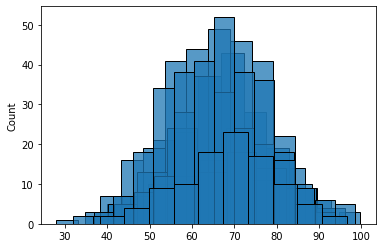

In [99]:
cheat_adv_list = [1.1, 1.2, 1.3]
prop_cheat_list = [0.1, 0.2, 0.3]

all_dists = pd.DataFrame()

for cheat_adv in cheat_adv_list:
    temp_list=[]
    for prop_cheats in prop_cheat_list:
        print(prop_cheats, cheat_adv)
        temp_list.append(multi_dist(mean=post_c_mean, median=post_c_median, stdev= post_c_stdev, cheat_adv=cheat_adv, prop_cheats=prop_cheats))
    all_dists.append(temp_list)
print(all_dists)


In [98]:
print(temp_list)

[]


In [40]:
print(np.mean(cheat_dist), np.mean(honest_dist), np.mean(total_dist))

74.92046602865292 68.0052793029933 69.38831664812521


In [41]:
print(np.std(cheat_dist), np.std(honest_dist), np.std(total_dist))

12.050237677780602 11.694348733821919 12.087143941267215


69.38831664812521 69.4
69.30062125824665 70.5
12.087143941267215 12.1


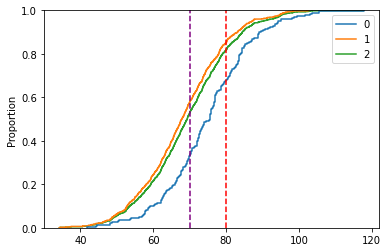

In [42]:
sns.ecdfplot([cheat_dist, honest_dist, total_dist])
plt.vlines(x=first_mark, ymin=0, ymax = 1, colors= 'purple', linestyles='dashed')
plt.vlines(x=first_mark+10, ymin=0, ymax = 1, colors= 'red', linestyles='dashed')
print(np.mean(total_dist), post_c_mean)
print(np.median(total_dist), post_c_median)
print(np.std(total_dist), post_c_stdev)

<AxesSubplot:ylabel='Density'>

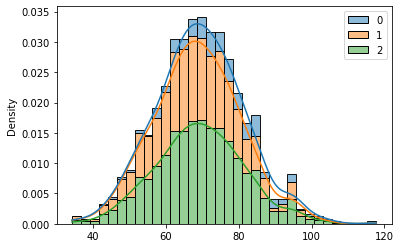

In [44]:
sns.histplot([cheat_dist, honest_dist, total_dist], kde=True, stat='density', multiple='stack')